In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Create dataset which is not easily linearly seperable

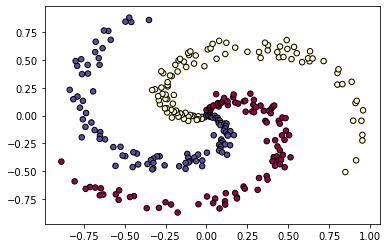

In [2]:
np.random.seed(0)

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Spectral, edgecolors='black')
plt.show()

### Create NN Objects

In [3]:
np.random.seed(0)
        
class Layers_Dense:
    def __init__(self, input_features, n_neurons):
        self.weights = np.random.randn(input_features,n_neurons) * 0.010 #To keep the weights small
        self.biases = np.zeros((1,n_neurons))
    def forward(self,inputs):
        self.output = np.dot(inputs,self.weights) + self.biases
    def update_parameters(self, dW,db):
        self.weights += dW
        self.biases += db

class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0,inputs)
        
class Average_Cross_Entropy:
    def compute_loss(self, predictions, true_labels,reg_strength,W,W2):
        num_examples = predictions.shape[0]
        exp_scores = np.exp(predictions)
        probs = exp_scores / np.sum(exp_scores,axis=1,keepdims=True)
        correct_logprobs = -np.log(probs[range(num_examples),true_labels])
        self.data_loss = (np.sum(correct_logprobs)/num_examples)
        reg_loss = 0.5*reg_strength*np.sum(W*W) + 0.5*reg_strength*np.sum(W2*W2)
        self.loss = self.data_loss + reg_loss
        dscores = probs
        dscores[range(num_examples),true_labels] -= 1
        dscores/=num_examples
        self.dscores = dscores

              
class Gradient_Descent:
    def __init__(self,learning_rate):
        self.step_size = -learning_rate
    def backprop(self,layer1,W,W2,dscores,X,reg_strength):
        dW2 = np.dot(layer1.T, dscores)
        dW2 += reg_strength * W2
        self.dW2 = dW2 * self.step_size
        self.db2 = (np.sum(dscores, axis=0, keepdims=True)) * self.step_size
        dhidden = np.dot(dscores, W2.T)
        dhidden[layer1 <= 0] = 0       
        dW = np.dot(X.T, dhidden)
        dW += reg_strength * W
        self.dW = dW * self.step_size
        self.db = (np.sum(dhidden, axis=0, keepdims=True)) * self.step_size

### Instansiate model

In [4]:
#Params
np.random.seed(0)

num_examples = X.shape[0]
num_features = X.shape[1]
K = 3 #num classes
n_neurons = 100
reg = 1e-3
learning_rate = 1

#Instantiate Model
layer1 = Layers_Dense(num_features,n_neurons)
activation1 = ReLU()
layer2 = Layers_Dense(n_neurons,K)
loss = Average_Cross_Entropy()
gd = Gradient_Descent(learning_rate)

### Train!

In [5]:
#Training Loop
np.random.seed(0)

tic = time.perf_counter()
for i in range(10000):
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    loss.compute_loss(layer2.output,y,reg,layer1.weights, layer2.weights)
    gd.backprop(activation1.output,layer1.weights, layer2.weights,loss.dscores,X,reg)
    layer2.update_parameters(gd.dW2,gd.db2)
    layer1.update_parameters(gd.dW,gd.db)

    if i % 1000 == 0:
        print('iteration %d loss %f' %(i, loss.loss))
toc = time.perf_counter()

print(f"Training time: {toc - tic:0.4f} seconds")

iteration 0 loss 1.098653
iteration 1000 loss 0.298058
iteration 2000 loss 0.256888
iteration 3000 loss 0.248453
iteration 4000 loss 0.246028
iteration 5000 loss 0.245497
iteration 6000 loss 0.245239
iteration 7000 loss 0.245081
iteration 8000 loss 0.244962
iteration 9000 loss 0.244786
Training time: 8.3358 seconds


In [6]:
# evaluate training set accuracy
np.random.seed(0)

layer1.forward(X)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
predicted_class = np.argmax(layer2.output, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.98
